# Snow Model
*R.A. Collenteur, University of Graz, 2021*

In this notebook it iss shown how to simulate groundwater recharge and levels when snow is of importance. 

In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions(numba=True, lmfit=True)

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.19.2
Scipy version: 1.6.0
Pandas version: 1.2.1
Pastas version: 0.17.0b
Matplotlib version: 3.3.2
lmfit version: 1.0.2
numba version: 0.51.2


## 1. Load data

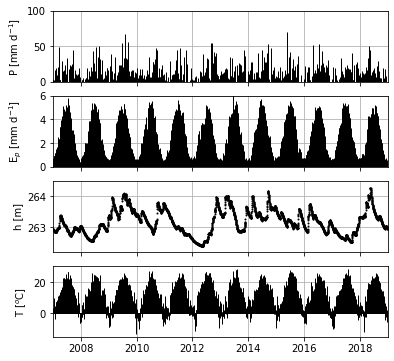

In [2]:
head = pd.read_csv("data_wagna/head_wagna.csv", index_col=0, parse_dates=True, squeeze=True, skiprows=2).loc["2006":]
evap = pd.read_csv("data_wagna/evap_wagna.csv", index_col=0, parse_dates=True, squeeze=True, skiprows=2)
rain = pd.read_csv("data_wagna/rain_wagna.csv", index_col=0, parse_dates=True, squeeze=True, skiprows=2)
temp = pd.read_csv("data_wagna/temp_wagna.csv", index_col=0, parse_dates=True, squeeze=True, skiprows=2)

### Create a plot of all the input data
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, sharex=True, figsize=(6,6))

ax1.vlines(rain.index, [0], rain.values, color="k", lw=1)
ax1.set_ylabel("P [mm d$^{-1}$]")
ax1.set_ylim(0, 100)
ax2.vlines(evap.index, [0], evap.values, color="k", lw=1)
ax2.set_ylabel("E$_p$ [mm d$^{-1}$]\n")
ax2.set_ylim(0, 6)
ax3.plot(head, marker=".", markersize=2, color="k", linestyle=" ")
ax3.set_ylabel("h [m]")
ax3.set_ylim(262.2, 264.5)
ax4.vlines(temp.index, [0], temp.values, color="k", lw=1)
ax4.set_ylabel("T [$^o$C]")

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid()

plt.xlim(pd.Timestamp("2007-01-01"), pd.Timestamp("2019-01-01"));

## 2. Create and calibrate a Pastas model

Fit report GWL                 Fit Statistics
nfev     63                     EVP          67.48
nobs     4375                   R2           0.67
noise    False                  RMSE         0.23
tmin     2008-01-01 00:00:00    AIC          nan
tmax     2019-12-31 00:00:00    BIC          nan
freq     D                      Obj          222.69
warmup   3650 days 00:00:00     ___             
solver   LmfitSolve             Interpolated  No

Parameters (7 were optimized)
               optimal stderr     initial   vary
rch_A         1.193837  ±nan%    0.680119   True
rch_a       137.777298  ±nan%   10.000000   True
rch_srmax    26.506467  ±nan%  250.000000   True
rch_lp        0.250000  ±nan%    0.250000  False
rch_ks       13.678532  ±nan%  100.000000   True
rch_gamma     8.480516  ±nan%    4.000000   True
rch_simax     2.000000  ±nan%    2.000000  False
rch_kv        1.000000  ±nan%    1.000000  False
rch_tp        2.000000  ±nan%    2.000000  False
rch_tk        2.000000  ±nan%    2

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=7)'}>,
 <AxesSubplot:title={'right':"Stresses: ['Precipitation', 'Evaporation', '0.7550996318722221']"}>,
 <AxesSubplot:xlabel='Time [days]'>]

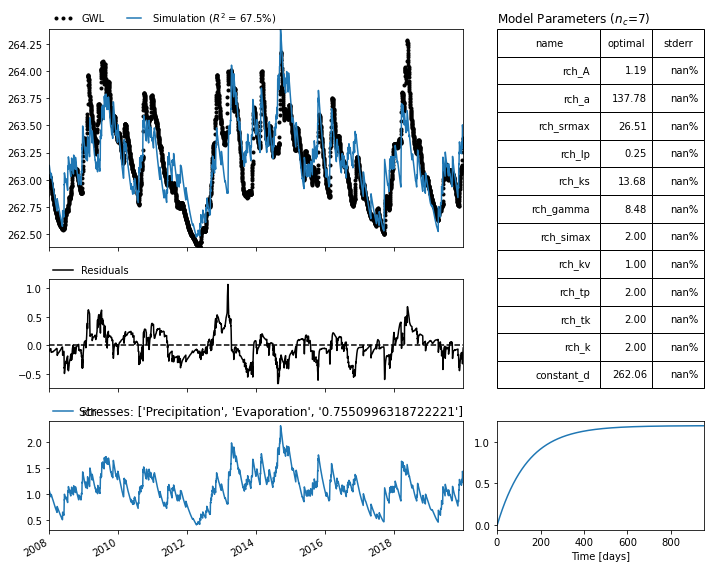

In [3]:
tmin = pd.Timestamp("2008-01-01") # Needs warmup
tmax = pd.Timestamp("2019-12-31")

ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, recharge=ps.rch.FlexSnowModel(), rfunc=ps.Exponential, name="rch", temp=temp)
ml.add_stressmodel(sm)

# In case of the non-linear model, change some parameter settings
#ml.set_parameter("rch_srmax", vary=False)
ml.set_parameter("rch_k", vary=True)
ml.set_parameter("constant_d", vary=True, initial=262, pmax=head.min())

# Add the ARMA(1,1) noise model and solve the Pastas model
ml.solve(tmin=tmin, tmax=tmax, noise=False, solver=ps.LmfitSolve, method="least_squares", report="basic")
ml.plots.results()

## 3. Study the fluxes

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

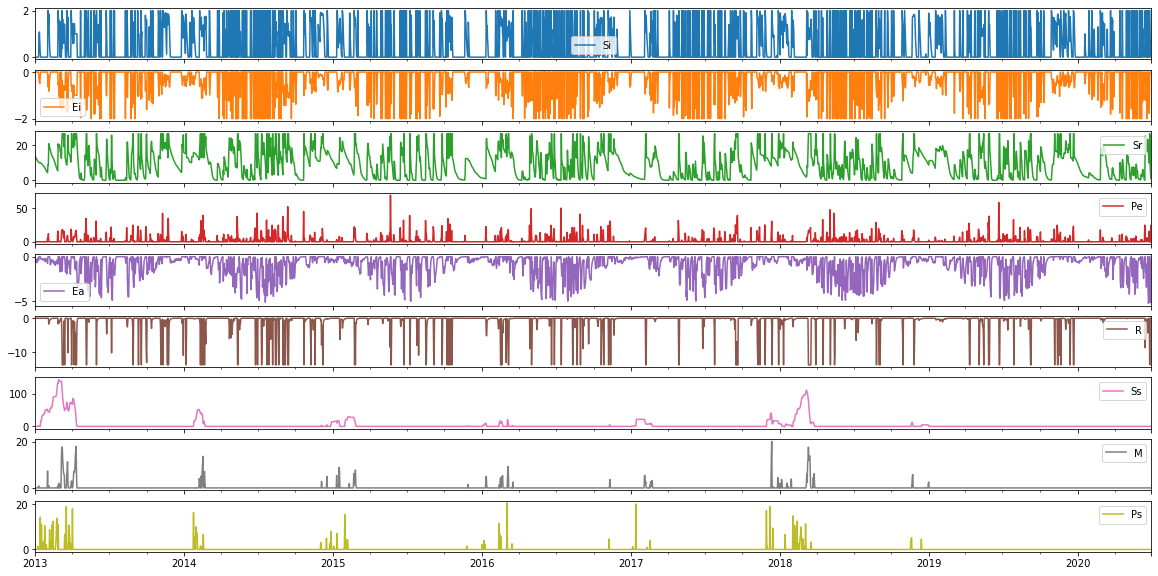

In [4]:
df = ml.stressmodels["rch"].get_water_balance(ml.get_parameters("rch"))
df.loc["2013":].plot(subplots=True, figsize=(20,10))